# HySwash: A hybrid method for nearshore wave processes

![sketch](./assets/hyswash-sketch.png)

## 1. Variables Selection

It is essential to carefully select the variables that will feed into the presented metamodel. The numerical model SWASH (Simulating WAves till SHore) is designed to solve the Navier-Stokes equations numerically, relying on key hydrodynamic input variables. Drawing from previous research on hydrodynamic modeling, it has been proven that the necessary variables encompass :
- Significant wave height (Hs)
- Wave slope (Hs/L0)
- VegetationHeight

However, when it comes to simulating the complex process of wave breaking in the nearshore zone, SWASH requires additional inputs to accurately reflect real-world conditions. The model alone cannot determine these parameters, necessitating user-defined inputs. Therefore, we also include the two critical coefficients responsible for governing wave breaking and energy dissipation: 
- Seabed friction coefficient (Cf)

Proper calibration of these coefficients is crucial for the model to realistically simulate wave behavior and energy dissipation in coral reef environments.

In [2]:
variables_to_analyse_in_metamodel = ["Hs", "Hs_L0", "vegetation_height"]

## 2. Sampling and Selection

The first step in implementing our metamodel involves generating and selecting specific representative cases that combine the variables previously identified. These combinations will accurately simulate realistic sea states in SWASH. Therefore, our task is to create realistic combinations of these variables to feed into the numerical model later on.

### 2.1. Latin Hypercube Sampling (LHS)

The Latin Hypercube Sampling (LHS) is a statistical technique designed to efficiently select parameter values across multiple dimensions while ensuring controlled randomness in the sampled data. To implement this technique, we start by establishing the limits for each variable.

In [3]:
from bluemath_tk.datamining.lhs import LHS

lhs_parameters = {
    "num_dimensions": 3,
    "num_samples": 10000,
    "dimensions_names": variables_to_analyse_in_metamodel,
    "lower_bounds": [0.5, 0.005, 0],
    "upper_bounds": [3, 0.05, 1.5],
}

lhs = LHS(
    num_dimensions=lhs_parameters.get("num_dimensions"),
)
df_dataset = lhs.generate(
    dimensions_names=lhs_parameters.get("dimensions_names"),
    lower_bounds=lhs_parameters.get("lower_bounds"),
    upper_bounds=lhs_parameters.get("upper_bounds"),
    num_samples=lhs_parameters.get("num_samples"),
)

2025-03-28 12:20:06,342 - LHS - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.


### 2.2 Maximum Dissimilarity Algorithm (MDA)

The high computational cost of propagating the entire hindcast dataset requires statistical tools to reduce the set of data to a number of representative cases to perform hybrid downscaling. The maximum dissimilarity algorithm (MDA) defined in the work of Camus et al., 2011, is implemented for this purpose.<br>
    <br>
Given a data sample $X=\{x_{1},x_{2},…,x_{N}\}$ consisting of $N$ $n$-dimensional vectors, a subset of $M$ vectors $\{v_{1},…,v_{M}\}$ representing the diversity of the data is obtained by applying this algorithm. The selection starts initializing the subset by transferring one vector from the data sample ${v_{1}}$. The rest of the $M-1$ elements are selected iteratively, calculating the dissimilarity between each remaining data in the database and the elements of the subset and transferring the most dissimilar one to the subset. The process finishes when the algorithm reaches $M$ iterations.

2025-03-28 12:20:07,120 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.


(<Figure size 640x480 with 3 Axes>,
 array([[<Axes: xlabel='Hs_L0', ylabel='Hs'>, <Axes: >],
        [<Axes: >, <Axes: xlabel='vegetation_height', ylabel='Hs_L0'>]],
       dtype=object))

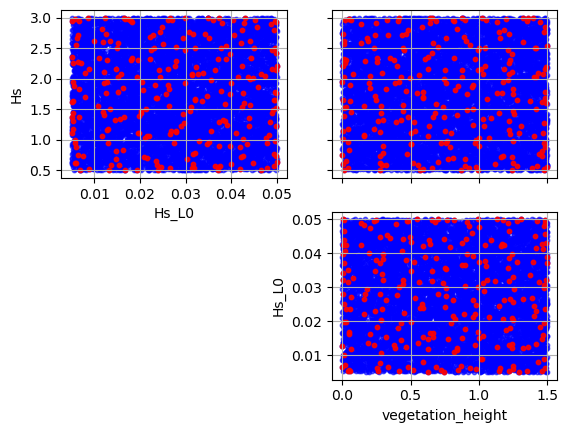

In [4]:
from bluemath_tk.datamining.mda import MDA

mda_parameters = {"num_centers": 250}

mda = MDA(num_centers=mda_parameters.get("num_centers"))
mda.fit(data=df_dataset, first_centroid_seed=88)
mda.plot_selected_centroids(plot_text=False)

In [5]:
mda.centroids

,Hs,Hs_L0,vegetation_height
0,1.630543,0.033692,1.372936
1,2.978748,0.005639,0.051580
2,0.513937,0.046528,0.013255
3,2.891252,0.048778,0.137877
4,0.618362,0.005685,0.520178
...,...,...,...
245,2.618823,0.009892,0.009759
246,0.634183,0.049983,0.699955
247,0.736691,0.042667,1.464337
248,0.709286,0.021577,0.811937


## 3. Numerical model SWASH

Once the hydrodynamic cases to be numerically simulated have been selected through the MDA algorithm, we proceed to launch these cases in SWASH. It is a versatile numerical tool designed to simulate a non-hydrostatic, phase-resolving wave model capable of simulating waves from deep waters to the shoreline, modeling wave breaking, bottom friction, wave- induced setup and runup, and the generation and propagation of infragravity waves (Delft University of Technology, n. d.).

In [ ]:
import os
import numpy as np
from bluemath_tk.wrappers.swash.swash_wrapper import SwashModelWrapper

# Define the input parameters
templates_dir = os.path.join(os.getcwd(), "templates")
# Get the centroids
metamodel_parameters = mda.centroids.to_dict(orient="list")
output_dir = os.path.join(os.getcwd(), "Runup_cases")
# Create an instance of the SWASH model wrapper
swash_model = SwashModelWrapper(
    templates_dir=templates_dir,
    metamodel_parameters=metamodel_parameters,
    fixed_parameters={},
    output_dir=output_dir,
    depth_array=np.loadtxt("templates/depth.bot"),
)

2025-03-28 10:58:36,387 - SwashModelWrapper - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.


In [6]:
swash_model.list_default_parameters()

,Hs,Hs_L0,WL,vegetation_height,dxinp,n_nodes_per_wavelength,comptime,warmup,gamma,deltat
type,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>
value,None,None,None,None,1.0,60,180,0,2,1
description,Significant wave height.,Wave height at deep water.,Water level.,The vegetation height.,The input spacing.,The number of nodes per wavelength.,The computational time.,The warmup time.,The gamma parameter.,The time step.


In [7]:
# Build the input files

swash_model.build_cases(mode="one_by_one")
# swash_model.set_cases_dirs_from_output_dir()

In [8]:
swash_model.list_available_launchers()

{'serial': 'swash_serial.exe',
 'mpi': 'mpirun -np 2 swash_mpi.exe',
 'docker_serial': 'docker run --rm -v .:/case_dir -w /case_dir geoocean/rocky8 swash_serial.exe',
 'docker_mpi': 'docker run --rm -v .:/case_dir -w /case_dir geoocean/rocky8 mpirun -np 2 swash_mpi.exe',
 'geoocean-cluster': 'launchSwash.sh'}

In [ ]:
# Run the model

swash_model.run_cases_in_background(launcher="serial", num_workers=3)

In [14]:
# Monitor the cases running

swash_model.monitor_cases()

,Case,Percentage
0,0000,100 %
1,0001,79 %
2,0002,100 %
3,0003,100 %
4,0004,100 %
...,...,...
245,0245,100 %
246,0246,100 %
247,0247,100 %
248,0248,100 %


## 4. Data Processing

The primary output variable generated by SWASH include the time series of water level along the profile. This output serves as crucial indicator of the hydrodynamic processes impacting the reef. From this SWASH output, we compute various other key variables. Different output quantities will be given here to go over the different wave transformation processes including wave propagation, dispersion, flooding and drying, moving shoreline, surf-beat, infragravity waves, set-up induced by wave breaking, run-up and overtopping discharge. 

- To this end, the time-dependent surface elevation is stored at every grid point for every time step. After removing the warmup time from the sea surface series, a FFt is applied to obtain its representation in the frequency domain. A further classification is given by spliting the wave frequency into incident waves IC (0.04 - 1), infragravity waves IG (0.004 - 0.04) and very low frequency VLF (0.001 - 0.004). 

- The run-up heigh is computed by the intersection between free surface and bottom level considering a minimun  depth of 1cm after each time step. 

- The mean wave overtopping discharge q (ms/l) is outputted at the highest elevation point.

In [15]:
swash_model.list_available_postprocess_vars()

['Ru2', 'Runlev', 'Msetup', 'Hrms', 'Hfreqs', 'Watlev']

In [16]:
# convert raw SWASH output to netcdf files (if output.nc NOT in case folder)
postprocessed_output = swash_model.postprocess_cases(output_vars=["Ru2"])

# import xarray as xr

# # Load output data if needed
# postprocessed_output = xr.open_dataset(
#     os.path.join(swash_model.output_dir, "output_postprocessed.nc")
# )

2025-03-28 11:11:18,181 - SwashModelWrapper - ERROR - Output not postprocessed for case 1. Error: index -1 is out of bounds for axis 0 with size 0.
2025-03-28 11:11:25,808 - SwashModelWrapper - ERROR - Output not postprocessed for case 15. Error: index -1 is out of bounds for axis 0 with size 0.
2025-03-28 11:13:56,830 - SwashModelWrapper - ERROR - Output not postprocessed for case 224. Error: index -1 is out of bounds for axis 0 with size 0.


<Axes: xlabel='Hs', ylabel='Hs_L0'>

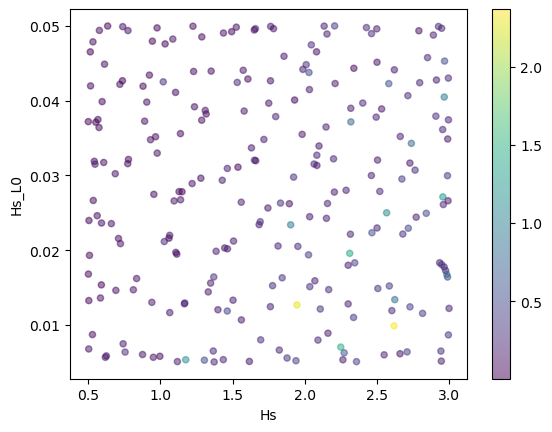

In [21]:
good_cases = mda.centroids.index.delete([1, 15, 224])
mda.centroids.iloc[good_cases].plot.scatter(
    x="Hs",
    y="Hs_L0",
    c=postprocessed_output.Ru2.values,
    colormap="viridis",
    alpha=0.5,
)

## 5. Reconstruction: Principal Component Analysis (PCA) & Radial Basis Fucntions (RBF)

The reconstruction of the time series of wave parameters in the position of the buoy is carried out by an interpolation technique based on radial basis functions (RBF), a scheme wich is very convenient for scatter and multivariate data. The RBF approximation has been applied successfully in many fields, usually with better results than other interpolation methods (Hardy, 1990).
    
Suppose that $f=f(x)$ is the real-valued function that we want to approximate. We are given M scattered data points $\{x_1,..., x_M\}$ of dimension $\textit{n}$ and the associated real function values $\{f_1, ..., f_M\}$, being $f_i = f(x_j), j = 1,...,M$. The RBF interpolation method consists of a weighted sum of radially symmetric basic functions located at the data points. The approximation function is assumed to be of the form:
$$RBF(x) = p(x) + \sum\limits_{j=1}^M a_j\Phi{\large (}{\large \parallel}{x - x_j}{\large \parallel}{\large )}$$

In [22]:
from bluemath_tk.interpolation.rbf import RBF

# Apply RBF reconstruction
rbf = RBF()
rbf.fit(
    subset_data=mda.centroids.iloc[postprocessed_output["case_num"].values, :],
    target_data=postprocessed_output.to_dataframe(),
)

2025-03-28 11:20:49,336 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


In [23]:
predicted_runups = rbf.predict(dataset=df_dataset)
closest_mda_centroids, _centroids_values = mda.predict(data=df_dataset)

2025-03-28 11:20:53,294 - RBF - WARNING - Proposed min custom scaler for Hs_L0 is bigger than datapoint
2025-03-28 11:20:53,295 - RBF - WARNING - Proposed min custom scaler for vegetation_height is bigger than datapoint
2025-03-28 11:20:53,296 - RBF - WARNING - Proposed max custom scaler for vegetation_height is lower than datapoint


In [24]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.linear_model import LinearRegression

# Your existing scatter plot
plot_df = pd.concat(
    [
        df_dataset,
        predicted_runups,
        pd.Series(closest_mda_centroids, name="bmus"),
    ],
    axis=1,
)
fig = px.scatter_3d(plot_df, x="Hs", y="Hs_L0", z="Ru2", color="Ru2", height=1000)

# Fit a plane to the data using linear regression
X = plot_df[["Hs", "Hs_L0"]].values
y = plot_df["Ru2"].values

model = LinearRegression().fit(X, y)
a = model.coef_[0]  # coefficient for Hs
b = model.coef_[1]  # coefficient for Hs_L0
c = model.intercept_  # intercept

# Create equation text for the annotation
equation = f"Ru2 = {a:.3f}×Hs + {b:.3f}×Hs_L0 + {c:.3f}"
r_squared = model.score(X, y)

# Define the range of your x and y values
x_range = [plot_df["Hs"].min(), plot_df["Hs"].max()]
y_range = [plot_df["Hs_L0"].min(), plot_df["Hs_L0"].max()]

# Create a grid for the fitted plane
x_plane = np.linspace(x_range[0], x_range[1], 10)
y_plane = np.linspace(y_range[0], y_range[1], 10)
x_grid, y_grid = np.meshgrid(x_plane, y_plane)

# Calculate z values for the fitted plane
z_plane = a * x_grid + b * y_grid + c

# Add the fitted plane to the figure
fitted_plane = go.Surface(
    x=x_grid,
    y=y_grid,
    z=z_plane,
    colorscale="Blues",
    showscale=False,
    opacity=0.4,
    name="Fitted Plane",
)
fig.add_trace(fitted_plane)

# Update layout for better visualization
fig.update_layout(
    scene=dict(xaxis_title="Hs", yaxis_title="Hs_L0", zaxis_title="Ru2"),
    title=f"{equation}<br>R² = {r_squared:.3f}",
    legend=dict(title="Ru2"),
)

# Add text annotation with the plane equation
# fig.add_annotation(
#     x=0.05,
#     y=0.95,
#     xref="paper",
#     yref="paper",
#     text=f"<b>Fitted plane:</b><br>{equation}<br>R² = {r_squared:.3f}",
#     showarrow=False,
#     font=dict(size=14),
#     bgcolor="white",
#     bordercolor="black",
#     borderwidth=1,
# )

fig.show()